In [1]:
# You should install minerva before running this script

#!pip install git+https://github.com/discovery-unicamp/Minerva-Dev.git
#!pip install kaleido

### Important imports

In [2]:
from minerva.models.nets.time_series.gans import GAN, TTSGAN_Encoder, TTSGAN_Discriminator, TTSGAN_Generator
from minerva.data.data_module_tools import RandomDataModule
import torch
import lightning as L
from torch.utils.data import DataLoader, Dataset, random_split

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from lightning.pytorch.callbacks import ModelCheckpoint
from callbacks import TsneGeneratorCallback, TsneEncoderCallback, KNNValidationCallback, MyPrintingCallback

import os
import pandas as pd
import numpy as np

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

device_number = 1
if torch.cuda.is_available():
    torch.cuda.set_device(device_number)

display(f"Using {device} device")

'Using cuda device'

In [4]:
torch.cuda.current_device()

1

In [5]:
experiment_number = 2
version = 6
n_epochs = 300
batch_size = 64
SAC = ['Sit', 'Stand', 'Walk', 'Upstairs', 'Downstairs', 'Run']
beta1 = 0.9
beta2 = 0.999
gen_lr = 0.0001
dis_lr = 0.0003
assimetrical_percentage = 1.0

### Data

In [6]:
import shutil

newpath = r'../../../standardize_view'

if os.path.exists(newpath):
    print("Directory already exists")
else:
    #os.makedirs(newpath)
    print("Directory created")
    !unzip ../../../standardized_view.zip?download=1 -d ../../../standardize_view

folder_to_delete = os.path.join(newpath, "RealWorld_upperarm")

if os.path.exists(folder_to_delete):
    shutil.rmtree(folder_to_delete)
    print(f"Deleting folder {folder_to_delete}")
else:
    print(f"Folder {folder_to_delete} not found. Experiments can be run freely")

print("initial download finished")

Directory already exists
Folder ../../../standardize_view/RealWorld_upperarm not found. Experiments can be run freely
initial download finished


In [7]:
dataNames = os.listdir(newpath)
dataNames.sort()
dataNames

['KuHar', 'MotionSense', 'RealWorld_thigh', 'RealWorld_waist', 'UCI', 'WISDM']

In [8]:
X = []
y = []   
for dataName in dataNames:
    print(dataName)
    dfTr = pd.read_csv(newpath + '/' + dataName + '/train.csv')
    X_tr = dfTr.values[:,:360].reshape(-1,6,60)
    y_tr = dfTr.values[:,-1].astype(np.int32)
    X.append(X_tr)
    y.append(y_tr)
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)
X.shape, y.shape

KuHar
MotionSense
RealWorld_thigh
RealWorld_waist
UCI
WISDM


((36788, 6, 60), (36788,))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 42)

X_train = torch.tensor(X_train.astype(np.float32), dtype=torch.float32, device=device).detach()
X_test = torch.tensor(X_test.astype(np.float32), dtype=torch.float32, device=device).detach()
y_train = torch.tensor(y_train.astype(np.float32), dtype=torch.float32, device=device).detach()
y_test = torch.tensor(y_test.astype(np.float32), dtype=torch.float32, device=device).detach()

X_train.shape, X_test.shape, y_train.shape, y_test.shape 

(torch.Size([29430, 6, 60]),
 torch.Size([7358, 6, 60]),
 torch.Size([29430]),
 torch.Size([7358]))

In [10]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, random_split

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class CustomDataModule(L.LightningDataModule):
    def __init__(self, data, labels, batch_size=16, val_split=0.2, num_workers=8):
        super().__init__()
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.val_split = val_split
        self.num_workers = num_workers

    def setup(self, stage=None):
        dataset = CustomDataset(self.data, self.labels)
        val_size = int(len(dataset) * self.val_split)
        train_size = len(dataset) - val_size
        self.train_dataset, self.val_dataset = random_split(dataset, [train_size, val_size])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

# Supondo que X seja seu dado com forma (36788, 6, 60)
#X = np.random.rand(36788, 6, 60).astype(np.float32)  # Certifique-se de que os dados sejam do tipo float32
#y = np.random.randint(0, 2, size=(36788,)).astype(np.float32)  # Rótulos fictícios para fins de exemplo

X = X.astype(np.float32)
y = y.astype(int)
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)

# Crie o DataModule
data_module = CustomDataModule(X_tensor, y_tensor, batch_size=64)

# Configure o DataModule
data_module.setup()

# Acesse os dataloaders
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

# Exemplo de iteração através do train_loader
print(len(train_loader))
print(len(val_loader))
for batch in train_loader:
    X_batch, y_batch = batch
    print(X_batch.shape, y_batch.shape)  # Deve imprimir torch.Size([64, 6, 60]) torch.Size([64])
    break

460
115
torch.Size([64, 6, 60]) torch.Size([64])


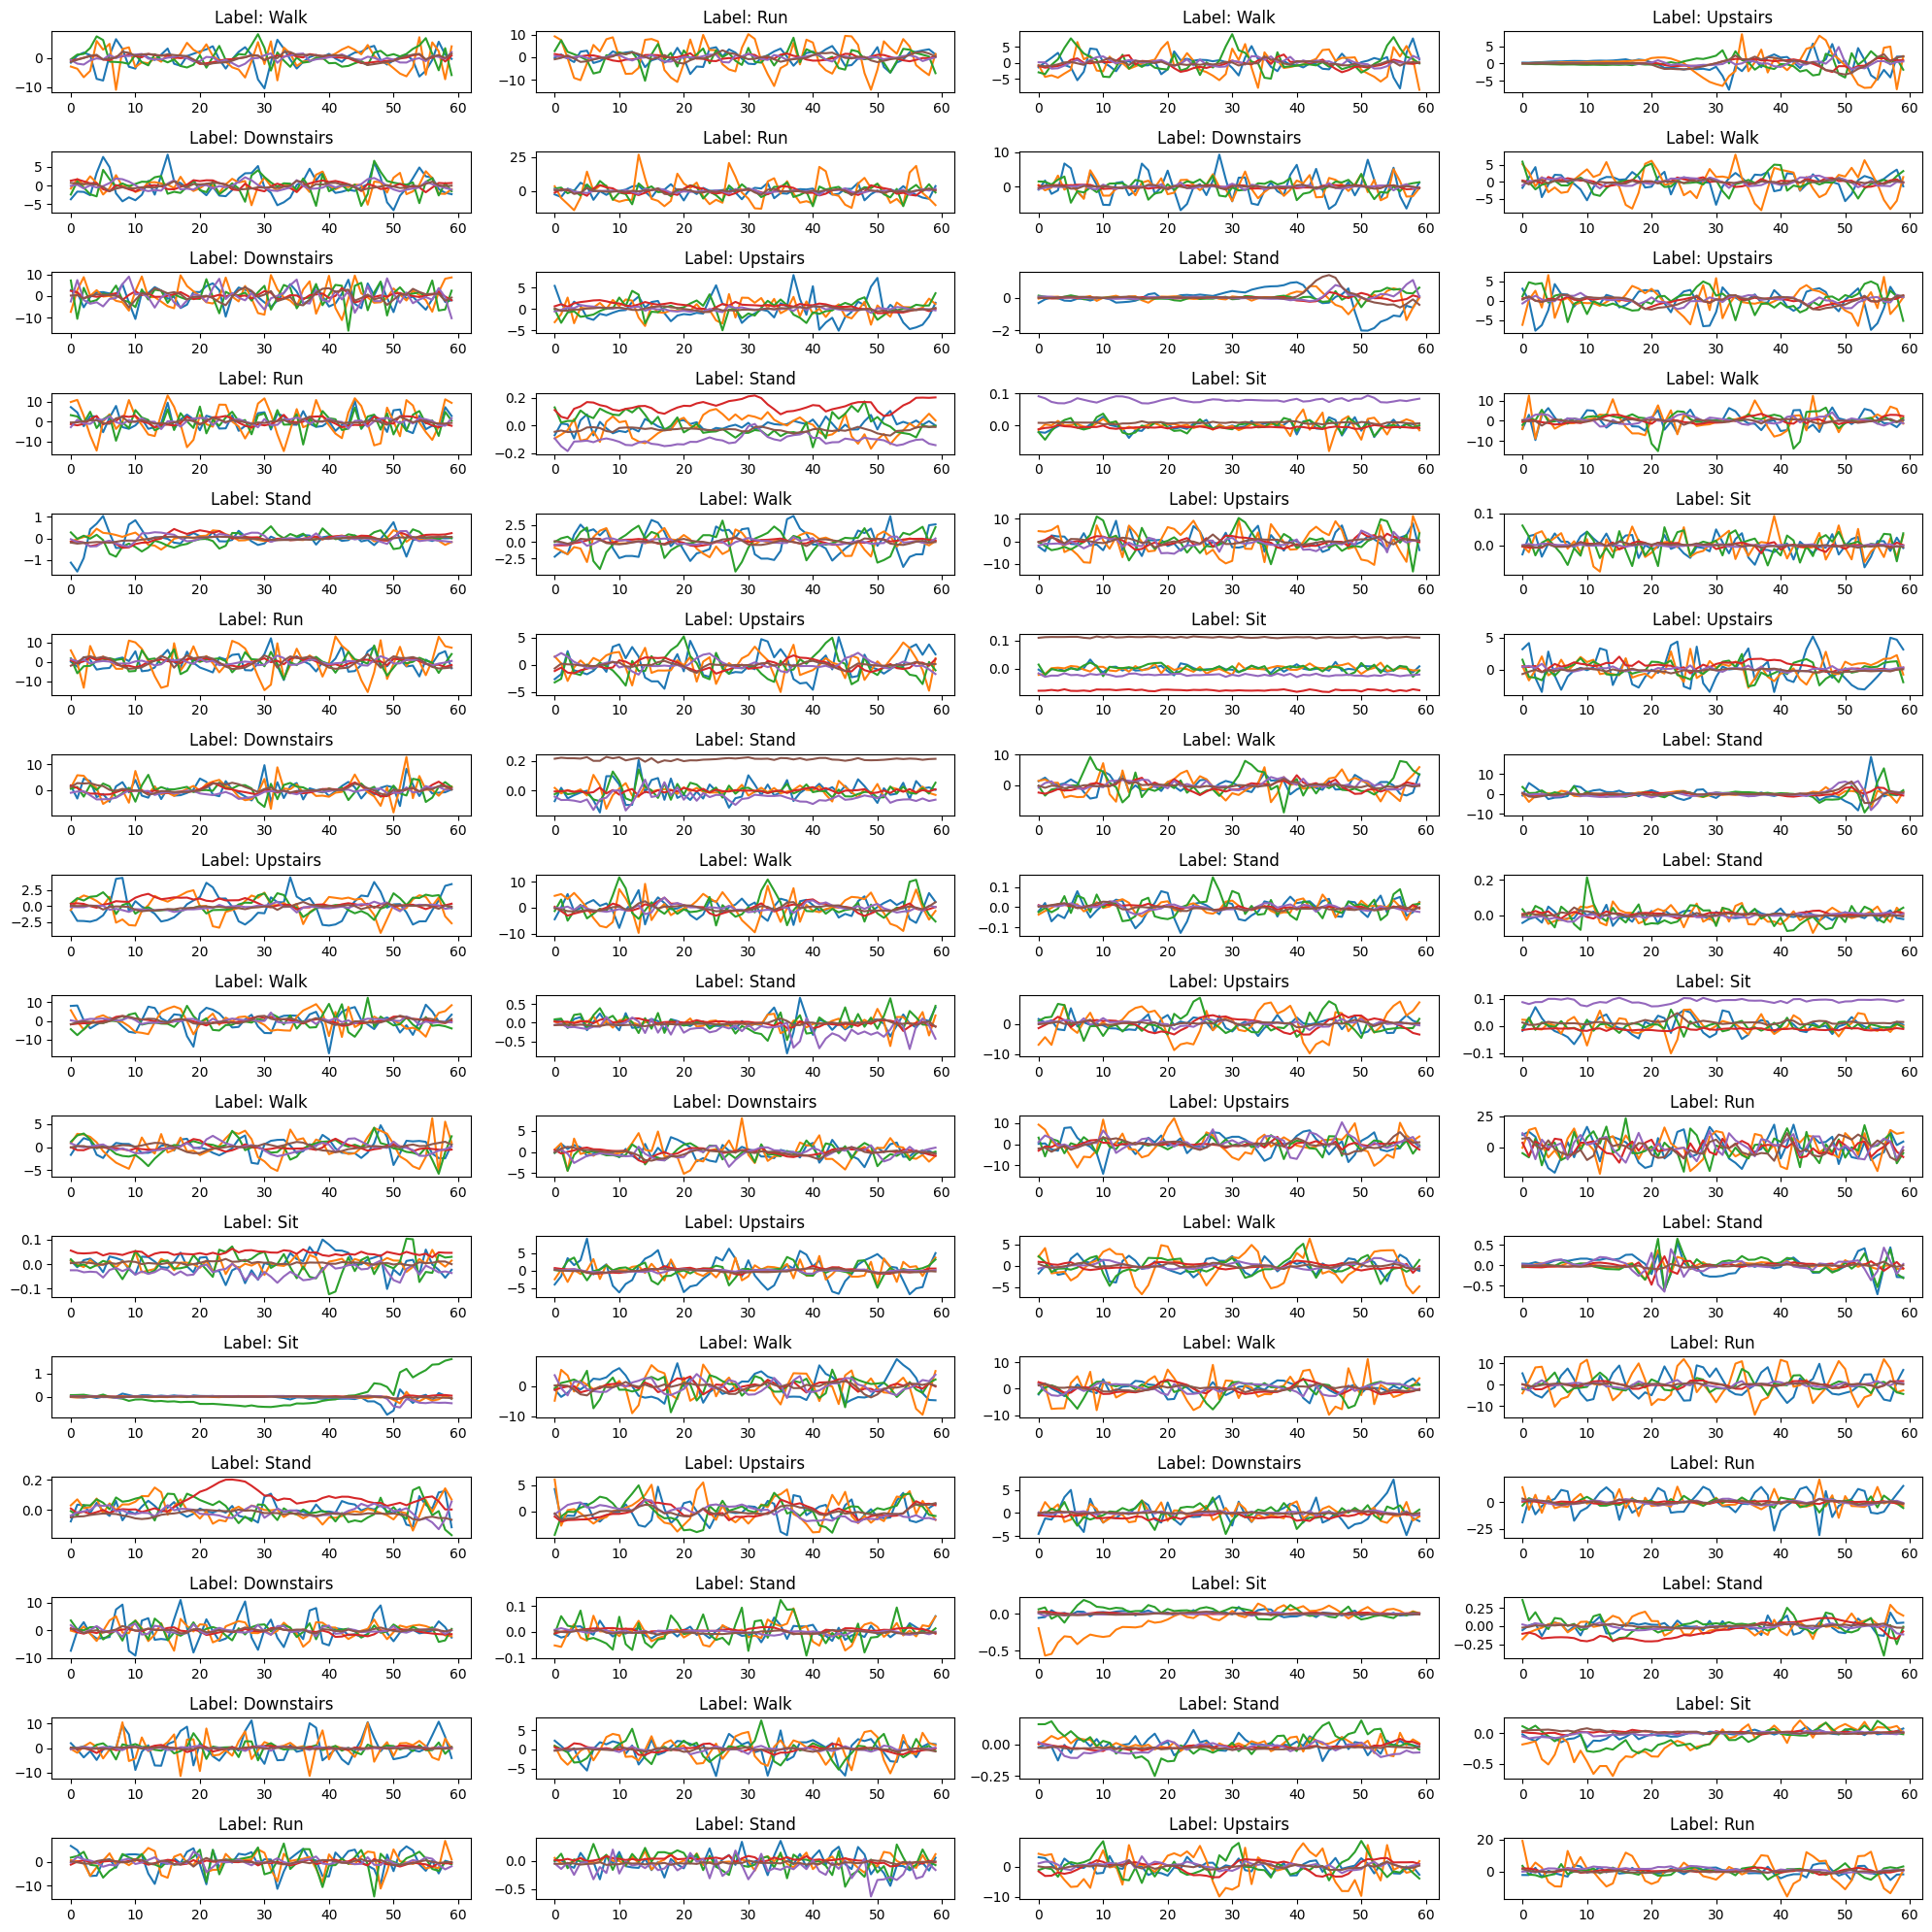

In [11]:
import matplotlib.pyplot as plt

def plot_batch(X_batch, y_batch):
    """
    Plota todos os b elementos do batch e escreve o título de cada subplot com o valor de y_batch[i].

    Parameters
    ----------
    X_batch : torch.Tensor
        O tensor contendo os dados do batch com shape (b, C, T).
    y_batch : torch.Tensor
        O tensor contendo os rótulos do batch com shape (b,).
    """
    num_samples = X_batch.shape[0]
    num_channels = X_batch.shape[1]
    time_steps = X_batch.shape[2]

    fig, axes = plt.subplots(num_samples // 4, 4, figsize=(20, 20))
    axes = axes.flatten()

    for i in range(num_samples):
        for j in range(num_channels):
            axes[i].plot(X_batch[i, j].cpu().numpy()) #, label=f'Channel {j+1}'
        axes[i].set_title(f'Label: {SAC[y_batch[i].item()]}')
        #axes[i].legend()

    plt.tight_layout()
    plt.show()

# Exemplo de uso
# Supondo que você tenha um batch de dados
for batch in train_loader:
    X_batch, y_batch = batch
    plot_batch(X_batch, y_batch)
    break  # Apenas para plotar o primeiro batch

In [12]:
'''
datamodule = RandomDataModule(
    data_shape = (6,60),
    num_classes = 6,
    num_train_samples = 8,
    num_val_samples = 8,
    num_test_samples= 8,
    batch_size = 16,
)
'''

'\ndatamodule = RandomDataModule(\n    data_shape = (6,60),\n    num_classes = 6,\n    num_train_samples = 8,\n    num_val_samples = 8,\n    num_test_samples= 8,\n    batch_size = 16,\n)\n'

In [13]:
generator = TTSGAN_Generator(seq_len = 60, channels = 6)
discriminator = TTSGAN_Discriminator(seq_len = 60, channels = 6)

model = GAN(generator = generator,
            discriminator = discriminator, 
            loss_gen = torch.nn.MSELoss(),
            loss_dis = torch.nn.MSELoss(),
            assimetrical_percentage = assimetrical_percentage,
            generator_lr = gen_lr,
            discriminator_lr = dis_lr,
            beta1 = beta1,
            beta2 = beta2,
            )
model

GAN(
  (gen): TTSGAN_Generator(
    (l1): Linear(in_features=100, out_features=600, bias=True)
    (blocks): Gen_TransformerEncoder(
      (0): Gen_TransformerEncoderBlock(
        (0): ResidualAdd(
          (fn): Sequential(
            (0): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
            (1): MultiHeadAttention(
              (keys): Linear(in_features=10, out_features=10, bias=True)
              (queries): Linear(in_features=10, out_features=10, bias=True)
              (values): Linear(in_features=10, out_features=10, bias=True)
              (att_drop): Dropout(p=0.5, inplace=False)
              (projection): Linear(in_features=10, out_features=10, bias=True)
            )
            (2): Dropout(p=0.5, inplace=False)
          )
        )
        (1): ResidualAdd(
          (fn): Sequential(
            (0): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
            (1): FeedForwardBlock(
              (0): Linear(in_features=10, out_features=40, bias=T

In [14]:
from lightning.pytorch.callbacks import ModelCheckpoint
from callbacks import TsneGeneratorCallback, TsneEncoderCallback, KNNValidationCallback, MyPrintingCallback

save_dir = './training'
name = 'ttsgan_minerva'

checkpoint_callback = ModelCheckpoint()
printing_callback = MyPrintingCallback()
knnvalidation_callback = KNNValidationCallback(k=10, flatten=True)
tsnecallbackgenerator = TsneGeneratorCallback(image_save_dir=f'{save_dir}/{name}/version_{version}/tsne/generator/')
tsnecallbackencoder = TsneEncoderCallback(image_save_dir=f'{save_dir}/{name}/version_{version}/tsne/encoder/', flatten=True)

In [15]:
from lightning.pytorch.loggers.csv_logs import CSVLogger

logger = CSVLogger(save_dir=save_dir, name=name, version=version)

In [16]:
trainer = L.Trainer(accelerator=device, devices=1,
                     callbacks=[printing_callback, knnvalidation_callback, tsnecallbackencoder],
                     logger=logger, max_epochs=n_epochs) #max_steps=50000

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [17]:
trainer.fit(model = model, datamodule = data_module)

/usr/local/lib/python3.10/dist-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory ./training/ttsgan_minerva/version_6 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory ./training/ttsgan_minerva/version_6/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                 | Params | Mode 
----------------------------------------------------------
0 | gen      | TTSGAN_Generator     | 65.3 K | train
1 | dis      | TTSGAN_Discriminator | 97.0 K | train
2 | loss_gen | MSELoss              | 0      | train
3 | loss_dis | MSELoss              | 0      | train
----------------------------------------------------------
162 K     Trainable params
0         Non-trainable params
162 K     Total params
0.649     Total estimated model params size (MB)
139 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  8.17it/s]

Training is starting                                                       
Epoch 299: 100%|██████████| 460/460 [00:23<00:00, 19.88it/s, v_num=6]

`Trainer.fit` stopped: `max_epochs=300` reached.


Training is ending
Epoch 299: 100%|██████████| 460/460 [00:30<00:00, 15.28it/s, v_num=6]


In [ ]:
import csv

def extract_losses(file_path):
    knn_validation = []

    with open(file_path, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            if 'knn_accuracy' in row and row['knn_accuracy']:
                knn_validation.append(float(row['knn_accuracy']))

        return knn_validation

# Exemplo de uso
#version = 6
file_path = f'{save_dir}/{name}/version_{version}/metrics.csv'
knn_loss  = extract_losses(file_path)
print("knn loss", knn_loss)

knn loss [0.2448146790266037, 0.2526884377002716, 0.4685562252998352, 0.45903199911117554, 0.46433091163635254, 0.4868919253349304, 0.4997861683368683, 0.5221021771430969, 0.5290114879608154, 0.5204450488090515, 0.5176118016242981, 0.5080875754356384, 0.4931486248970032, 0.4775102436542511, 0.46077823638916016, 0.4533187747001648, 0.4512673616409302, 0.43455541133880615, 0.43387606739997864, 0.42544546723365784, 0.42583972215652466, 0.44242915511131287, 0.44936519861221313, 0.4492360055446625, 0.4507305920124054, 0.4478706419467926, 0.44583258032798767, 0.44229328632354736, 0.43767374753952026, 0.43672263622283936, 0.4300583600997925, 0.425167053937912, 0.42231377959251404, 0.4185027480125427, 0.4168723225593567, 0.416471391916275, 0.41701486706733704, 0.41701486706733704, 0.4172799289226532, 0.4190462529659271, 0.41958972811698914, 0.42108428478240967, 0.4242092967033386, 0.4235232472419739, 0.43303412199020386, 0.43577155470848083, 0.4393041729927063, 0.4398476481437683, 0.4413355290

In [67]:
from scipy.signal import find_peaks

vales, _ = find_peaks(-np.array(knn_loss))
picos, _ = find_peaks(knn_loss)

In [77]:
vales

array([  3,  19,  23,  35,  43,  51,  55,  76,  84,  86,  93,  96, 105,
       111, 115, 121, 123, 125, 127, 130, 135, 138, 141, 144, 147, 149,
       152, 158, 161, 165, 169, 172, 178, 180, 183, 186, 188, 190, 192,
       197, 199, 201, 203, 205, 212, 215, 218, 223, 227, 230, 235, 238,
       240, 245, 247, 250, 255, 257, 259, 261, 264, 268, 271, 275, 278,
       281, 283, 287, 290, 292, 294])

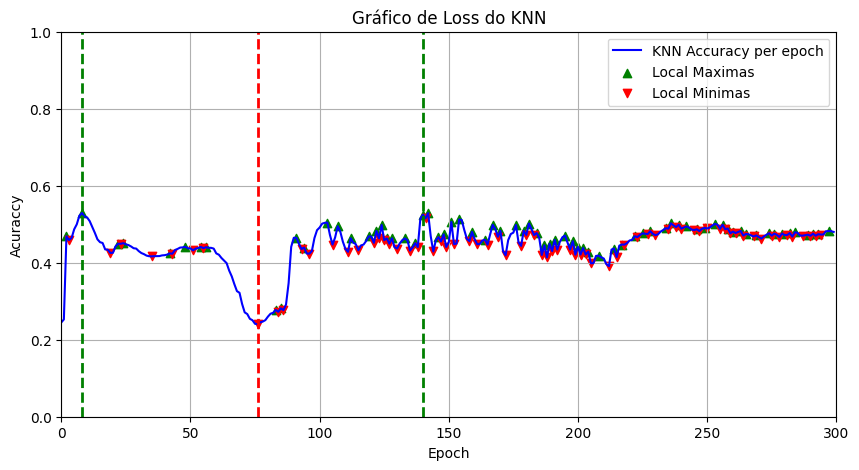

In [79]:
import matplotlib.pyplot as plt

# Criar uma lista de índices de 0 a 100
indices = list(range(len(knn_loss)))

# Criar o gráfico
plt.figure(figsize=(10, 5))
plt.plot(indices, knn_loss, marker='', linestyle='-', color='b', label='KNN Accuracy per epoch')

plt.scatter(picos, np.array(knn_loss)[picos], color='green', marker='^', label='Local Maximas')
plt.scatter(vales, np.array(knn_loss)[vales], color='red', marker='v', label='Local Minimas')

plt.axvline(x=8, color='g', linestyle='--', linewidth=2)
plt.axvline(x=140, color='g', linestyle='--', linewidth=2)

plt.axvline(x=76, color='r', linestyle='--', linewidth=2)
#plt.axvline(x=140, color='g', linestyle='--', linewidth=2)


plt.xlabel('Epoch')
plt.ylabel('Acuraccy')
plt.title('Gráfico de Loss do KNN')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)  # Ajustar o limite do eixo y para melhor visualização
plt.xlim(0, len(knn_loss))



# Mostrar o gráfico
plt.show()

In [20]:
ckp = torch.load(f='/workspaces/vinicius.garcia/Projetos/tts-gan/Notebooks/Minerva_experiments' \
                '/training/ttsgan_minerva/version_0/checkpoints/epoch=299-step=276000.ckpt')
generator = TTSGAN_Generator(seq_len = 60, channels = 6)
discriminator = TTSGAN_Discriminator(seq_len = 60, channels = 6)

test_gan = GAN(generator = generator,
            discriminator = discriminator, 
            loss_gen = torch.nn.MSELoss(),
            loss_dis = torch.nn.MSELoss(),
            )
test_gan.load_state_dict(ckp['state_dict'])
#print(ckp['state_dict'])

<All keys matched successfully>